In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

# Figure

## Sejourn Time

In [3]:
from itertools import groupby

def sejourn_time_seq(seq, times):
    boutypes, sejourns = [], []
    start = 0
    for key, group in groupby(seq):
        n = len(list(group))
        stop = start + n
        if n == 1:
            sejourn = times[start+1] - times[start]
        else:        
            sejourn = times[stop] - times[start]#times[start:stop].sum()
        boutypes.append(key)
        sejourns.append(sejourn)
        start = stop
    
    return np.array(boutypes), np.array(sejourns)

def sejourn_time_seqs(seqs, times):
    BTs, DTs = [], []
    for seq, time in zip(seqs, times):
        bts, dts = sejourn_time_seq(seq, time)
        BTs.append(bts)
        DTs.append(dts)
    return np.concatenate(BTs), np.concatenate(DTs)

### Behavior

In [4]:
from utils.data_and_models import format_sequences

In [5]:
behav = h5py.File(bDATAPATH, "r")

BTs, DTs = [], []
for temp in TEMPS:
    v = load_viterbi(bMODELPATH, "g3", temp)
    dt = format_sequences(behav[f"behaviour/{temp}/bouttime"][()])
    bts, dts = sejourn_time_seqs(v, dt)
    BTs.append(bts)
    DTs.append(dts)
BTs, DTs = np.concatenate(BTs), np.concatenate(DTs)
sF_beh = DTs[BTs == 0]
sL_beh = DTs[BTs == 1]
sR_beh = DTs[BTs == 2]

behav.close()

In [6]:
BTs

array([0, 2, 0, ..., 2, 1, 2])

Text(0, 0.5, 'Density')

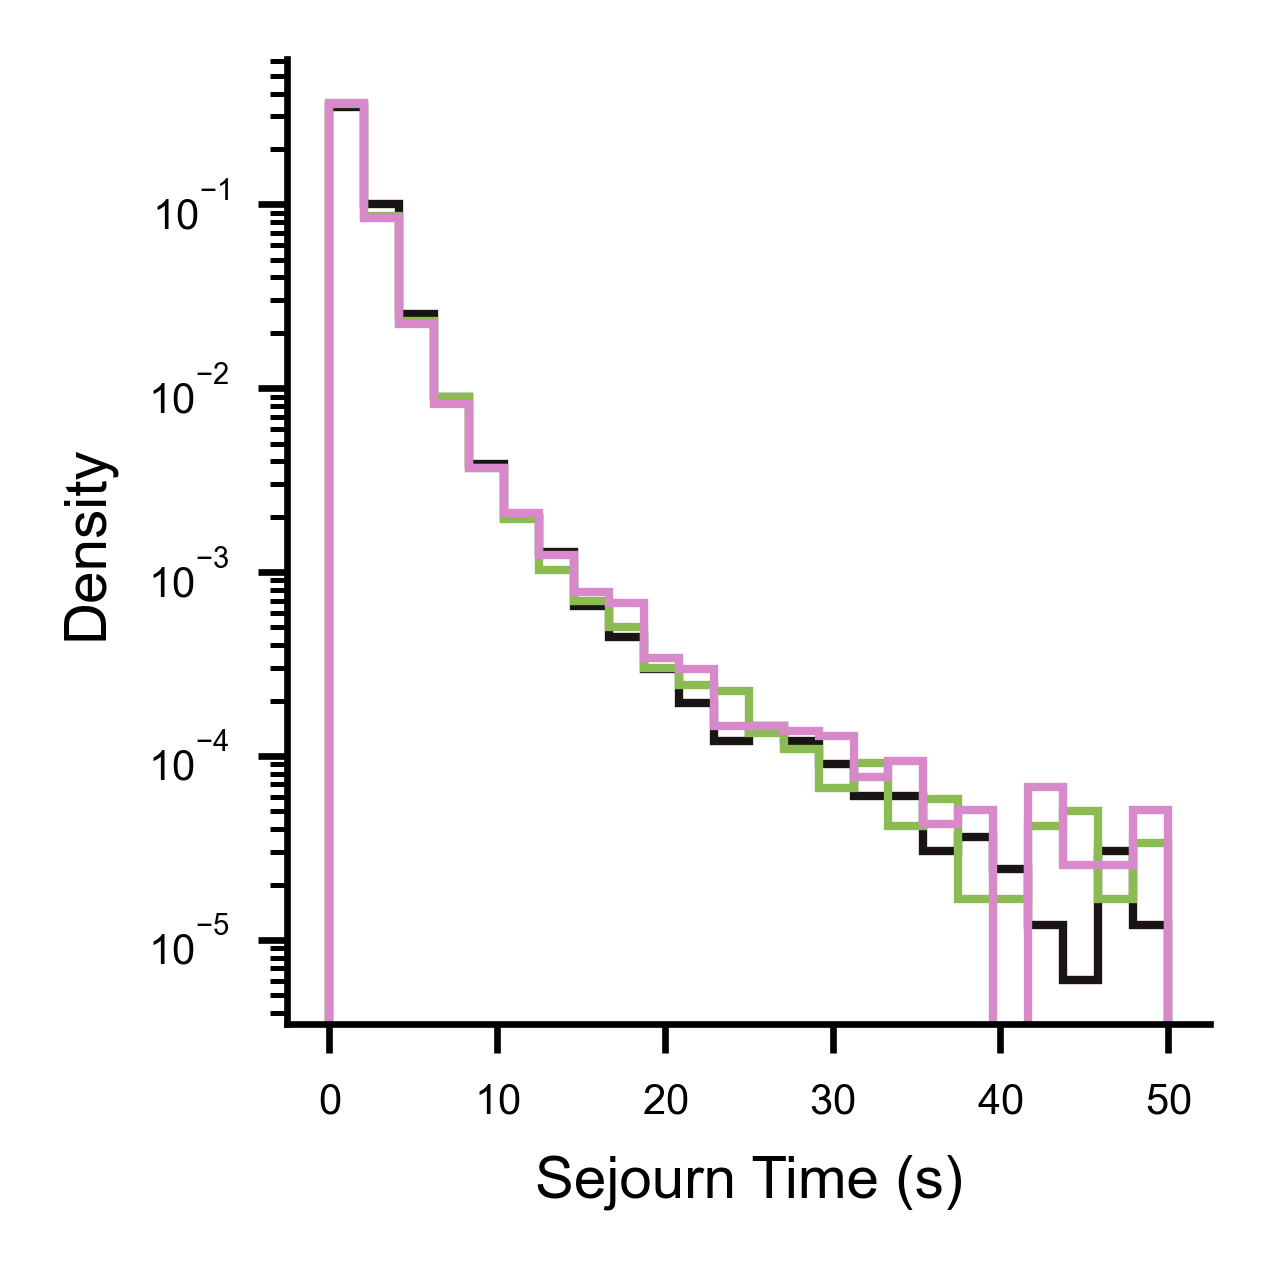

In [7]:
fig, ax = plt.subplots()
bins = np.linspace(0,50, 25)
ax.hist(sF_beh, bins, histtype="step", density=True, color=FLR_colors[0]);
ax.hist(sL_beh, bins, histtype="step", density=True, color=FLR_colors[1]);
ax.hist(sR_beh, bins, histtype="step", density=True, color=FLR_colors[2]);
ax.set_yscale("log")
ax.set_xlabel("Sejourn Time (s)")
ax.set_ylabel("Density")

### neuro

In [8]:
sFs, sLs, sRs = [], [], []
dts = []
for artr in ALL_ARTRs:
    dt = load_ARTR_dt(nMODELPATH, *artr)
    sF, sL, sR = load_ARTR_sejourn(nMODELPATH, *artr)
    sFs.append(sF)
    sLs.append(sL)
    sRs.append(sR)
    dts.append(dt)
sF_neu = np.concatenate(sFs)
sL_neu = np.concatenate(sLs)
sR_neu = np.concatenate(sRs)

Text(0, 0.5, 'Density')

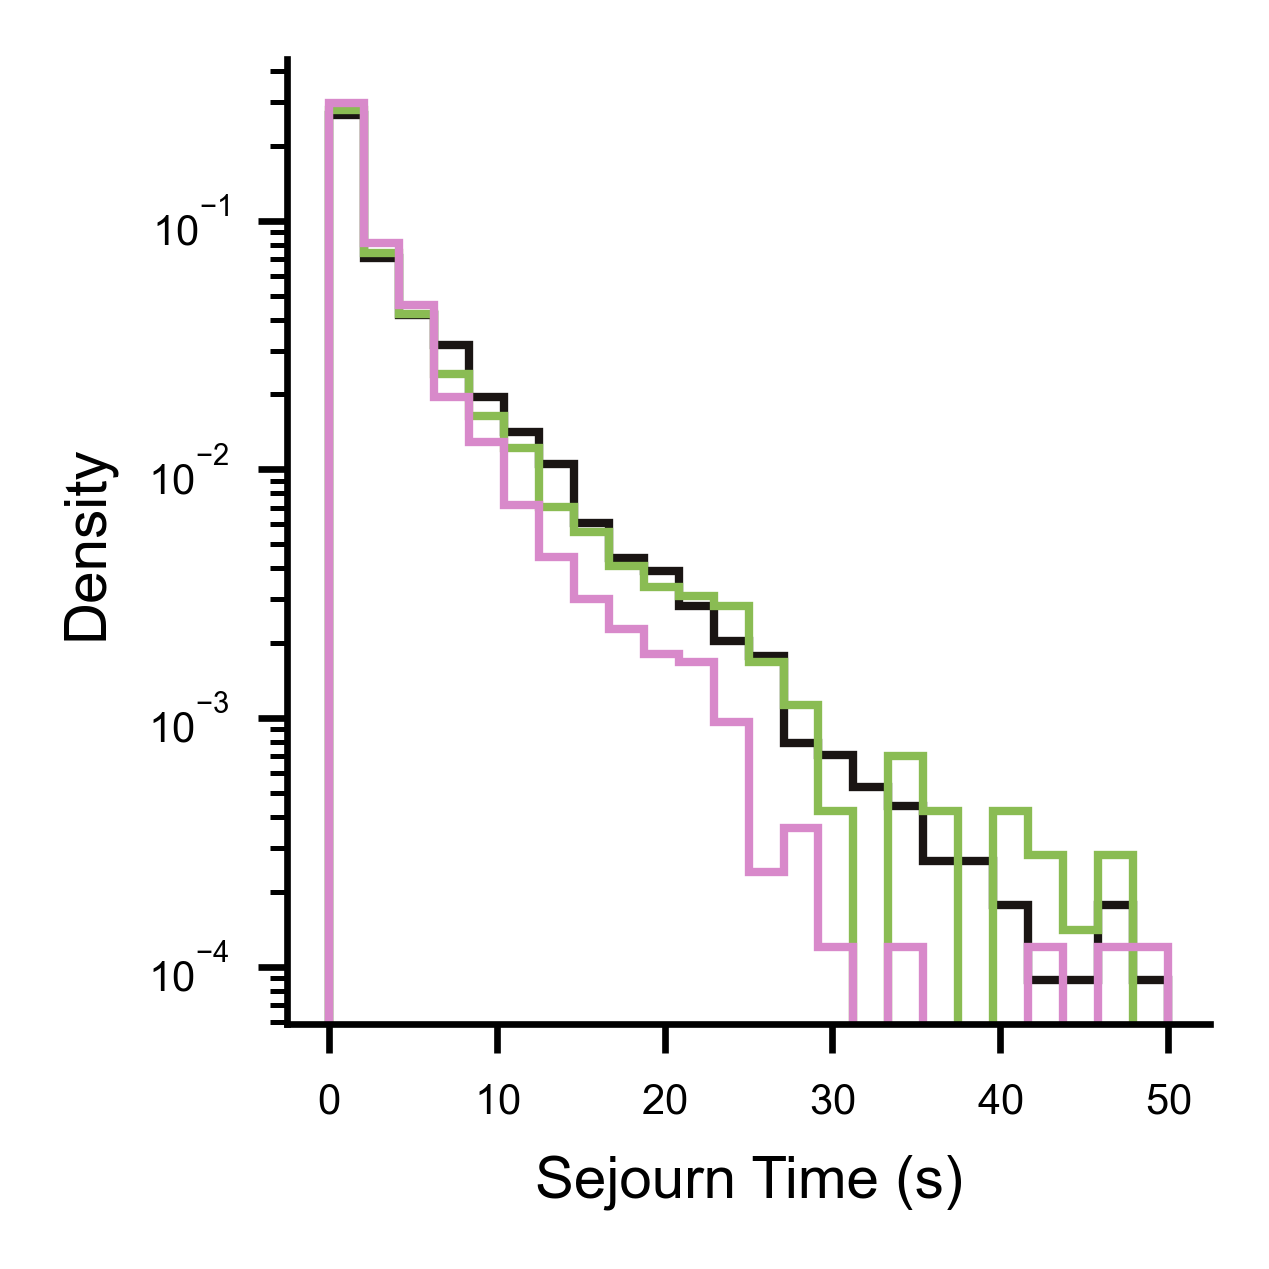

In [9]:
fig, ax = plt.subplots()
bins = np.linspace(0,50, 25)
ax.hist(sF_neu, bins, histtype="step", density=True, color=FLR_colors[0]);
ax.hist(sL_neu, bins, histtype="step", density=True, color=FLR_colors[1]);
ax.hist(sR_neu, bins, histtype="step", density=True, color=FLR_colors[2]);
ax.set_yscale("log")
ax.set_xlabel("Sejourn Time (s)")
ax.set_ylabel("Density")

### rescaling

In [10]:
from sklearn.metrics import root_mean_squared_error as rmse

def distrib_diff(dt, A, B):
    qs = np.linspace(0,0.99, 1000)
    return rmse(
        np.quantile(A, qs),
        np.quantile(B*dt, qs),
    )

In [11]:
factors = np.linspace(0,1,50)
diffs = np.array([distrib_diff(dt, np.concatenate([sF_beh, sL_beh,sR_beh]), np.concatenate([sF_neu, sL_neu,sR_neu])) for dt in factors])
delta_t = factors[np.argmin(diffs)]

In [12]:
delta_t = 0.44

### Panel

Text(0.5, 1.0, 'Turns')

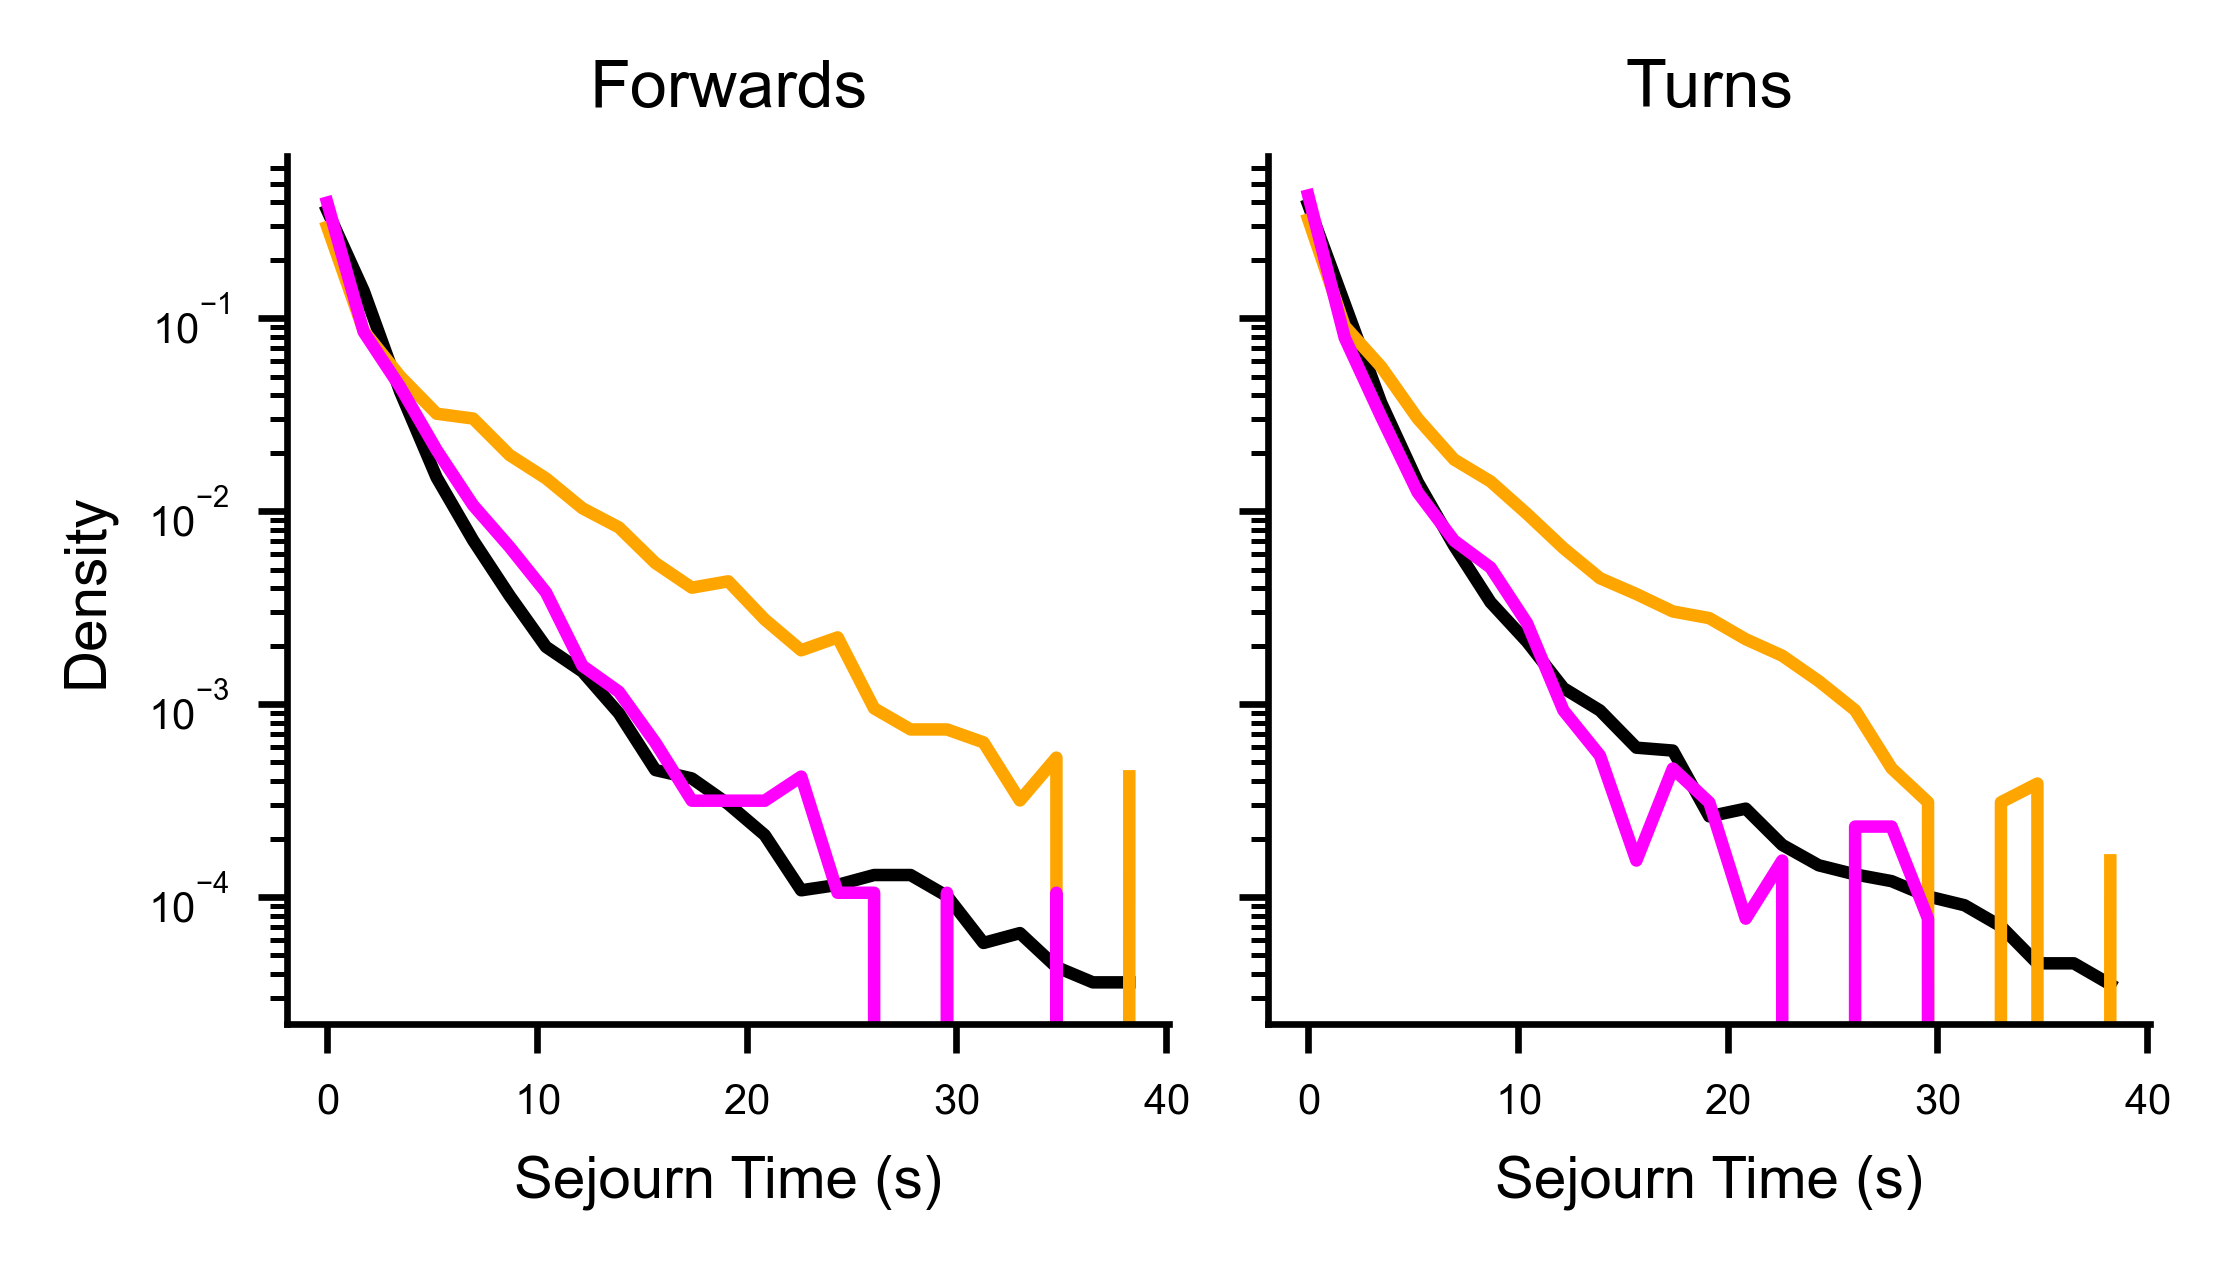

In [81]:
fig, axs = plt.subplots(ncols=2, figsize=(2*1.8,2), sharex=True, sharey=True)
bins = np.linspace(0,40,24)

ax = axs[0]
hF_neu, _ = np.histogram(sF_neu, bins, density=True)
hF_neu_scaled, _ = np.histogram(sF_neu*delta_t, bins, density=True)
hF_beh, _ = np.histogram(sF_beh, bins, density=True)
ax.plot(bins[:-1], hF_beh, color="k", linestyle="-")
ax.plot(bins[:-1], hF_neu, color="orange", linestyle="-")
ax.plot(bins[:-1], hF_neu_scaled, color="magenta", linestyle="-")
ax.set_yscale("log")
ax.set_xlabel("Sejourn Time (s)")
ax.set_ylabel("Density")
ax.set_title("Forwards")

ax = axs[1]
hT_neu, _ = np.histogram(np.concatenate([sL_neu,sR_neu]), bins, density=True)
hT_neu_scaled, _ = np.histogram(np.concatenate([sL_neu,sR_neu])*delta_t, bins, density=True)
hT_beh, _ = np.histogram(np.concatenate([sL_beh,sR_beh]), bins, density=True)
ax.plot(bins[:-1], hT_beh, color="k", linestyle="-", label="Behavior")
ax.plot(bins[:-1], hT_neu, color="orange", linestyle="-", label="Neuro")
ax.plot(bins[:-1], hT_neu_scaled, color="magenta", linestyle="-", label="rescale Neuro")
ax.set_yscale("log")
ax.set_xlabel("Sejourn Time (s)")
#ax.set_ylabel("Density")
ax.set_title("Turns")
#ax.legend()

#fig.savefig("panels/Fig5/sejorn_rescale.svg")

## Transition matrices

In [13]:
from scipy.stats import spearmanr
from sklearn.metrics import root_mean_squared_error as rmse

In [14]:
# Behaviour
bT = np.empty((len(TEMPS), 3,3))
for t, temp in enumerate(TEMPS):
    bT[t,:,:] = load_transmat(bMODELPATH, "g3", temp)

In [15]:
# Neuro
nT = []
nTemps = []
ndt = []
for artr in ALL_ARTRs:
    nT.append(load_ARTR_transmat(nMODELPATH, *artr))
    ndt.append(load_ARTR_dt(nMODELPATH, *artr))
    nTemps.append(artr[1])
nT = np.array(nT)
ndt = np.array(ndt)
nTemps = np.array(nTemps)

nPowers = np.round(1/(ndt*delta_t)).astype(int)
nSimplePowers = np.round(1/(ndt)).astype(int)

scaled_nT = np.array([np.linalg.matrix_power(T,p) for T,p in zip(nT, nPowers)])
scaledSimple_nT = np.array([np.linalg.matrix_power(T,p) for T,p in zip(nT, nSimplePowers)])

In [16]:
nPowers, nSimplePowers

(array([11, 19, 19, 11, 19, 19,  8,  8, 11, 11, 11, 11, 19, 19,  8,  8,  8,
        11, 11, 11, 19, 19, 19,  8,  8, 11, 11, 11, 19, 19, 15, 23]),
 array([ 5,  8,  8,  5,  8,  8,  3,  3,  5,  5,  5,  5,  8,  8,  3,  3,  3,
         5,  5,  5,  8,  8,  8,  3,  3,  5,  5,  5,  8,  8,  7, 10]))

In [17]:
f"{nPowers.mean():0.1f} ± {nPowers.std():0.1f}" , f"{nSimplePowers.mean():0.1f} ± {nSimplePowers.std():0.1f}"

('13.6 ± 4.7', '5.8 ± 2.1')

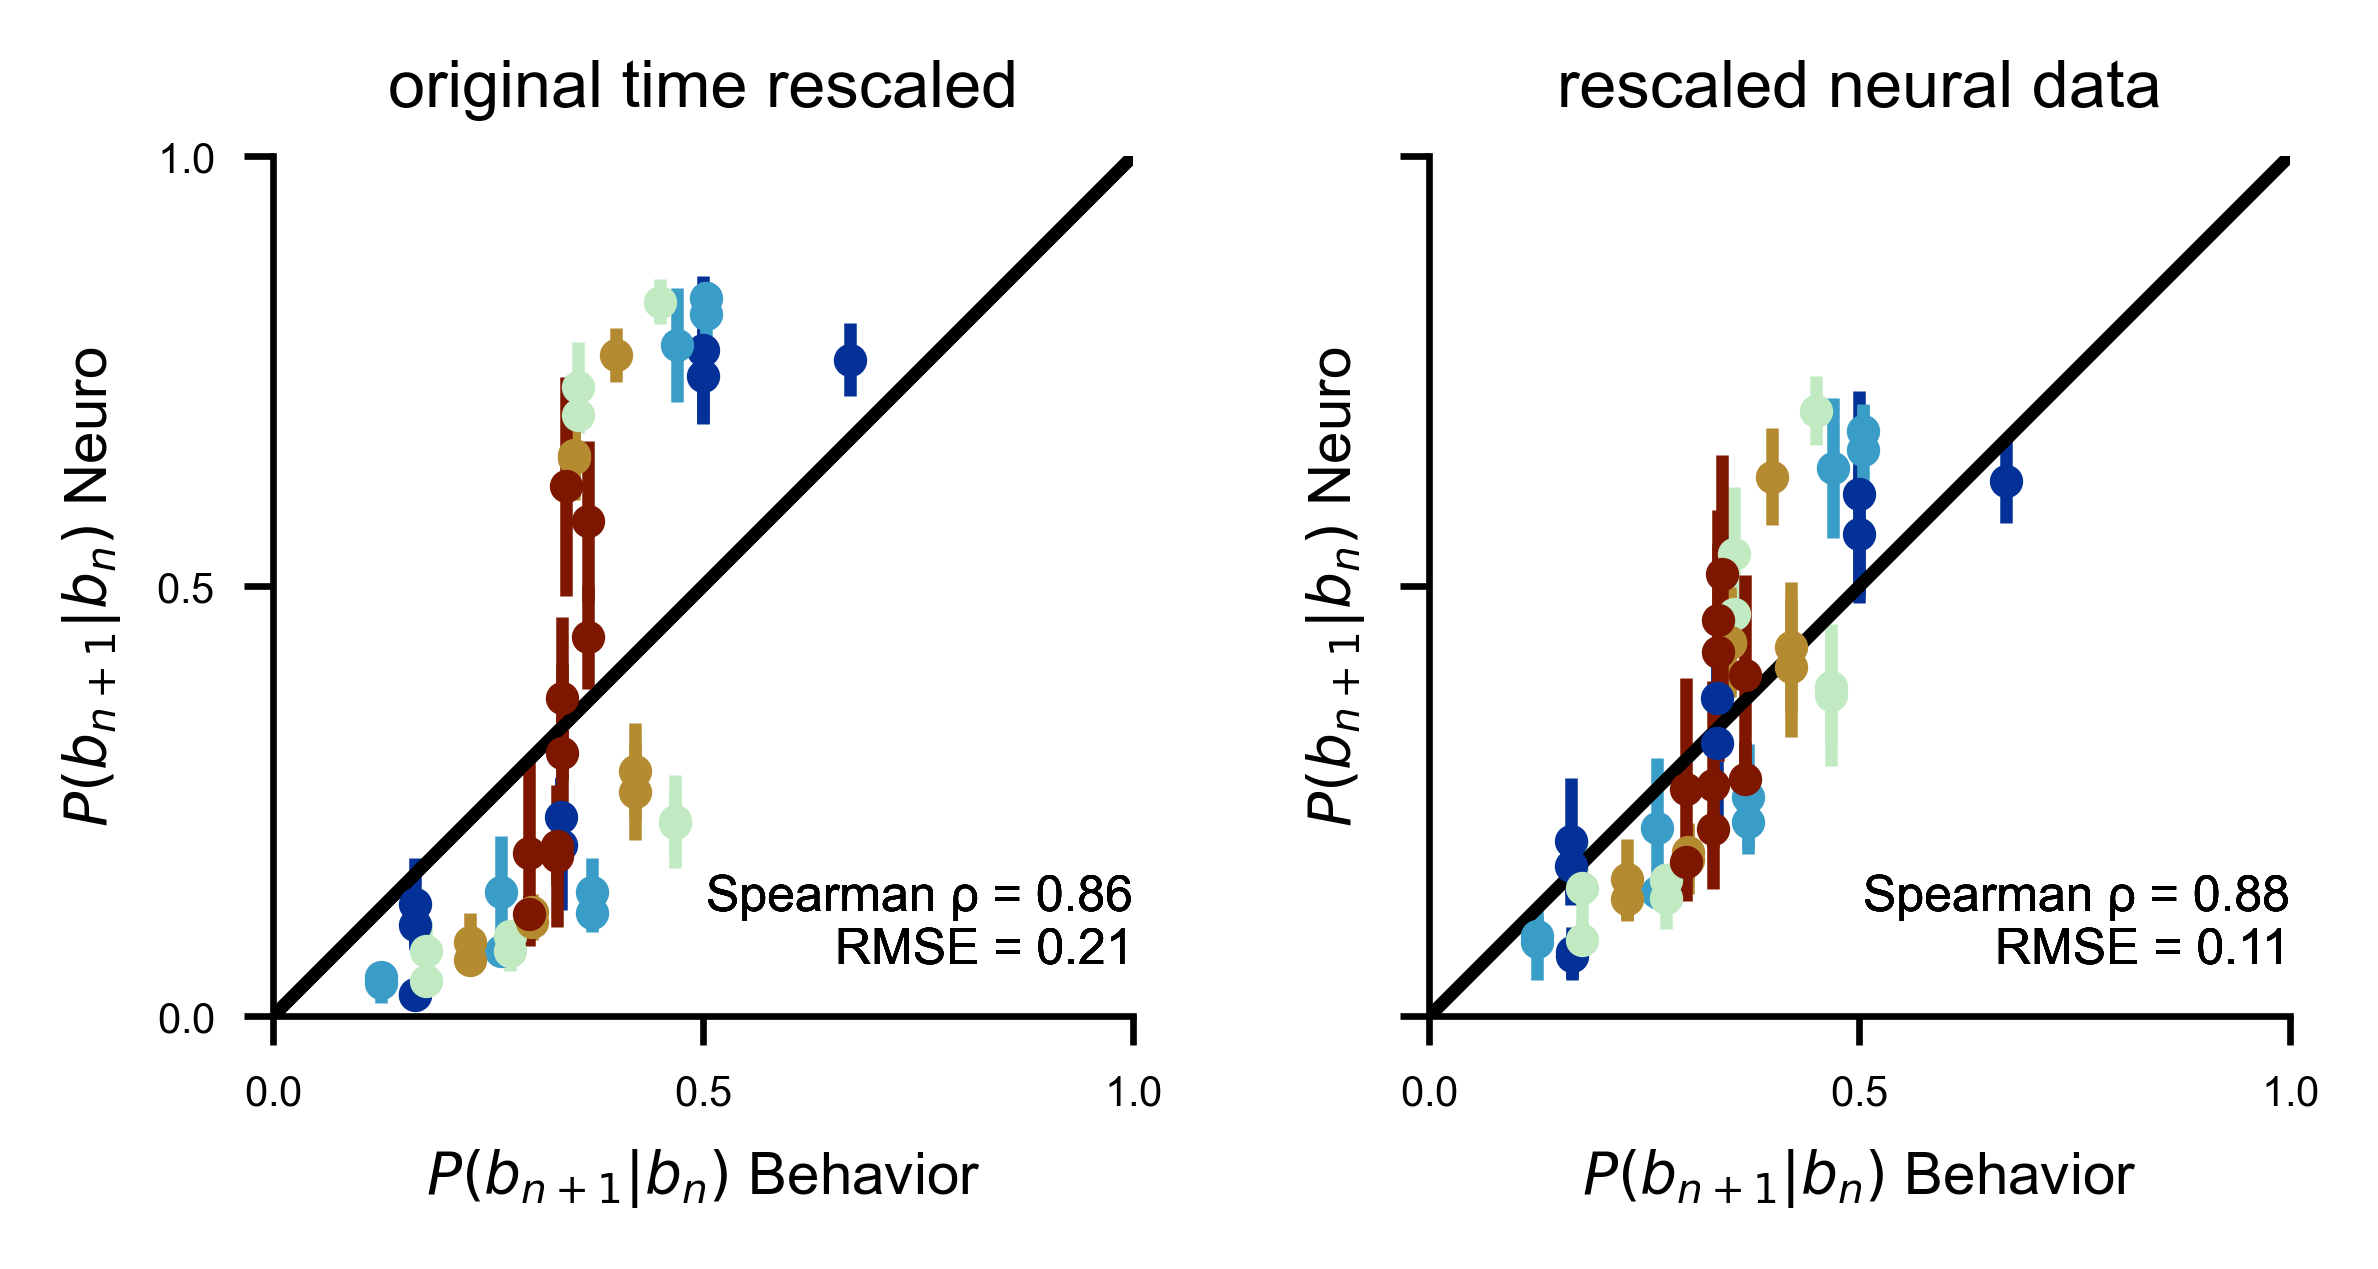

In [87]:
def plot_id_transmat(ax, X,Y):
    for t,temp in enumerate(TEMPS):
        T = Y[nTemps==temp, :,:]
        ax.errorbar(
            X[t,:,:].ravel(), 
            T.mean(axis=0).ravel(), 
            yerr=T.std(axis=0, ddof=1).ravel() / np.sqrt(len(T)), 
            fmt="o", 
            color=TEMPS_COLS[temp], 
            markersize=3
        )
        ax.plot([0,1],[0,1], color="k")
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_xlabel(r"$P(b_{n+1} | b_{n})$ Behavior")
        ax.set_ylabel(r"$P(b_{n+1} | b_{n})$ Neuro")
        x = X.ravel()
        y = np.array([ Y[nTemps==temp].mean(axis=0)  for temp in TEMPS]).ravel()
        rho = spearmanr(x,y).statistic
        r = np.corrcoef(x,y)[0,1]
        r = rmse(x,y)
        ax.annotate(f"Spearman ρ = {rho:0.2f}\nRMSE = {r:0.2f}", (1,0.05), ha="right", va="bottom")
        ax.set_aspect(1)

fig, axs = plt.subplots(ncols=2, figsize=(2*2,2), sharex=True, sharey=True)

ax = axs[0]
plot_id_transmat(ax, bT, scaledSimple_nT)
ax.set_title("original time rescaled")
ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

ax = axs[1]
plot_id_transmat(ax, bT, scaled_nT)
ax.set_title("rescaled neural data")

fig.savefig("panels/Fig5/idT.svg")

## L→F→R

In [163]:
import matplotlib.gridspec as gridspec

In [98]:
fL = nT[:,1,2] / nT[:,1,0]
fR = nT[:,2,1] / nT[:,2,0]
fL[~np.isfinite(fL)] = 0
fR[~np.isfinite(fR)] = 0

fsL = scaled_nT[:,1,2] / scaled_nT[:,1,0]
fsR = scaled_nT[:,2,1] / scaled_nT[:,2,0]
fsL[~np.isfinite(fsL)] = 0
fsR[~np.isfinite(fsR)] = 0

xBT = np.array([load_transmat_multi(bMODELPATH, "g3", temp) for temp in TEMPS])
fB = (xBT[:,:,1,2] / xBT[:,:,1,0]).ravel()

/tmp/ipykernel_277529/4255883753.py:1: RuntimeWarning: divide by zero encountered in divide
  fL = nT[:,1,2] / nT[:,1,0]


/tmp/ipykernel_277529/1861468110.py:48: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig("panels/Fig5/LFR.svg")
/opt/miniconda3/envs/ZebrafishHMM2024/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/opt/miniconda3/envs/ZebrafishHMM2024/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


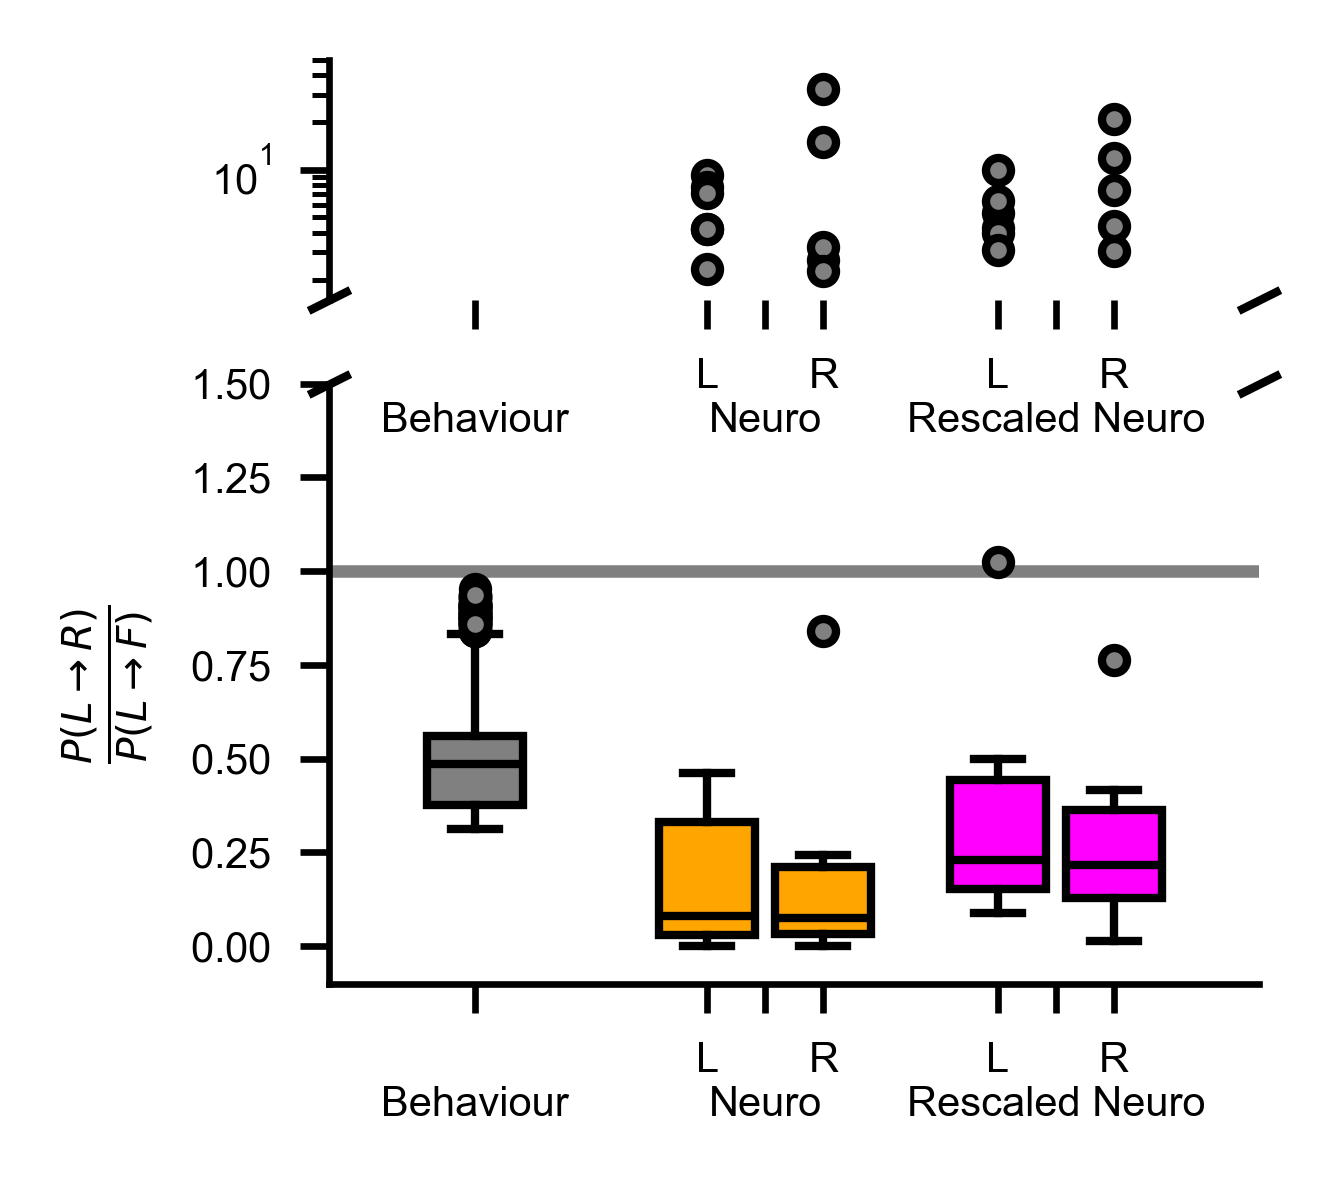

In [172]:
pad = 0.2

medianprops = dict(linestyle='-', linewidth=1, color='k')
flierprops = dict(marker='o', markerfacecolor='grey', markersize=3, markeredgecolor='k')

def plot(ax, log=True):
    bplot = ax.boxplot(
        [fB, fL,fR, fsL, fsR], 
        #showfliers=log, 
        positions=[0, 1-pad,1+pad, 2-pad,2+pad],
        patch_artist=True,
        medianprops=medianprops,
        flierprops=flierprops
    )
    ax.axhline(1, color="grey", zorder=0)
    if log:
        ax.set_yscale("log")
    
    for patch, color in zip(bplot["boxes"], ["grey", "orange","orange", "magenta","magenta"]):
        patch.set_facecolor(color)

#fig, (axup, axdown) = plt.subplots(nrows=2, sharex=True)
#fig.subplots_adjust(hspace=0.05)
fig = plt.figure()
gs = gridspec.GridSpec(2,1, height_ratios=[1,2.5])
axdown = plt.subplot(gs[1])
axup = plt.subplot(gs[0], sharex=axdown)

plot(axup)
plot(axdown, log=False)

axdown.set_ylim(-0.1,1.5)
axup.set_ylim(1.5, 50)
axup.spines.bottom.set_visible(False)
axdown.spines.top.set_visible(False)
axdown.set_xticks([])

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axup.plot([0, 1], [0, 0], transform=axup.transAxes, **kwargs)
axdown.plot([0, 1], [1, 1], transform=axdown.transAxes, **kwargs)


axdown.set_xticks([0, 1-pad,1+pad, 2-pad,2+pad, 1, 2], ["\nBehaviour", "L", "R", "L", "R", "\nNeuro", "\nRescaled Neuro"])
axdown.set_ylabel(r"$\frac{P(L\rightarrow R)}{P(L\rightarrow F)}$")

fig.savefig("panels/Fig5/LFR.svg")

# Supplementaries

## Rescaling factor

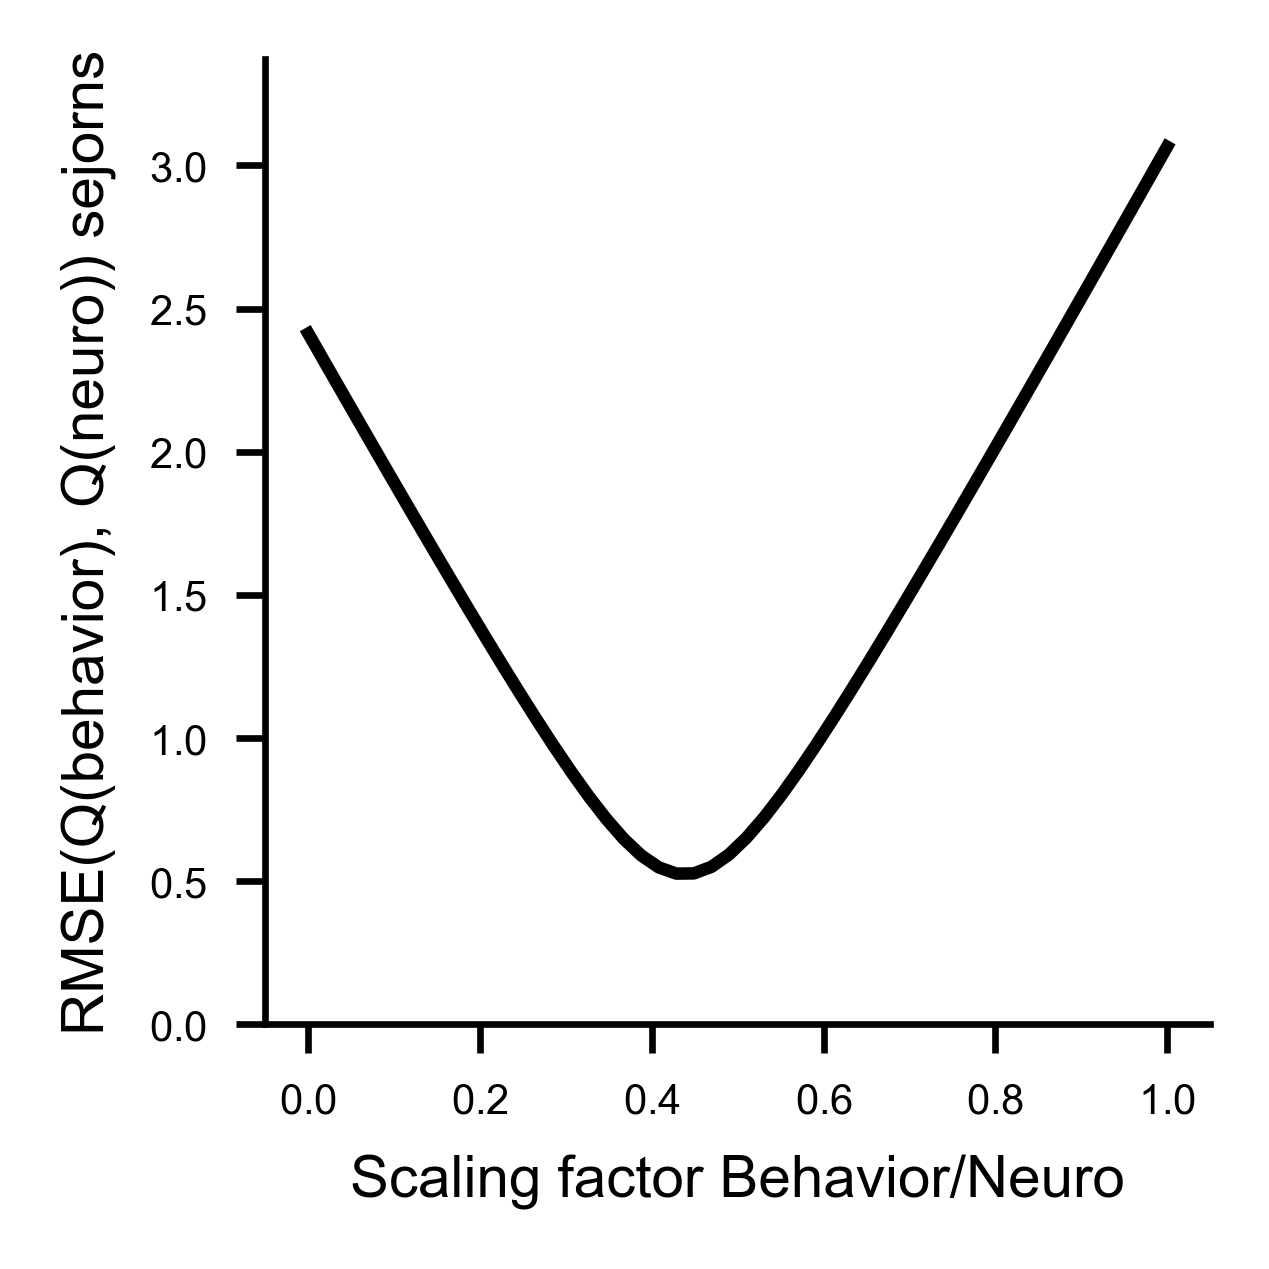

In [88]:
fig, ax = plt.subplots()
ax.plot(factors, diffs)
ax.set_xlabel("Scaling factor Behavior/Neuro")
ax.set_ylabel("RMSE(Q(behavior), Q(neuro)) sejorns")
ax.set_ylim(0, diffs.max()*1.1)
fig.savefig("panels/Fig5/supps/scaling_factor.svg")

## Rescaling factor - per Temp

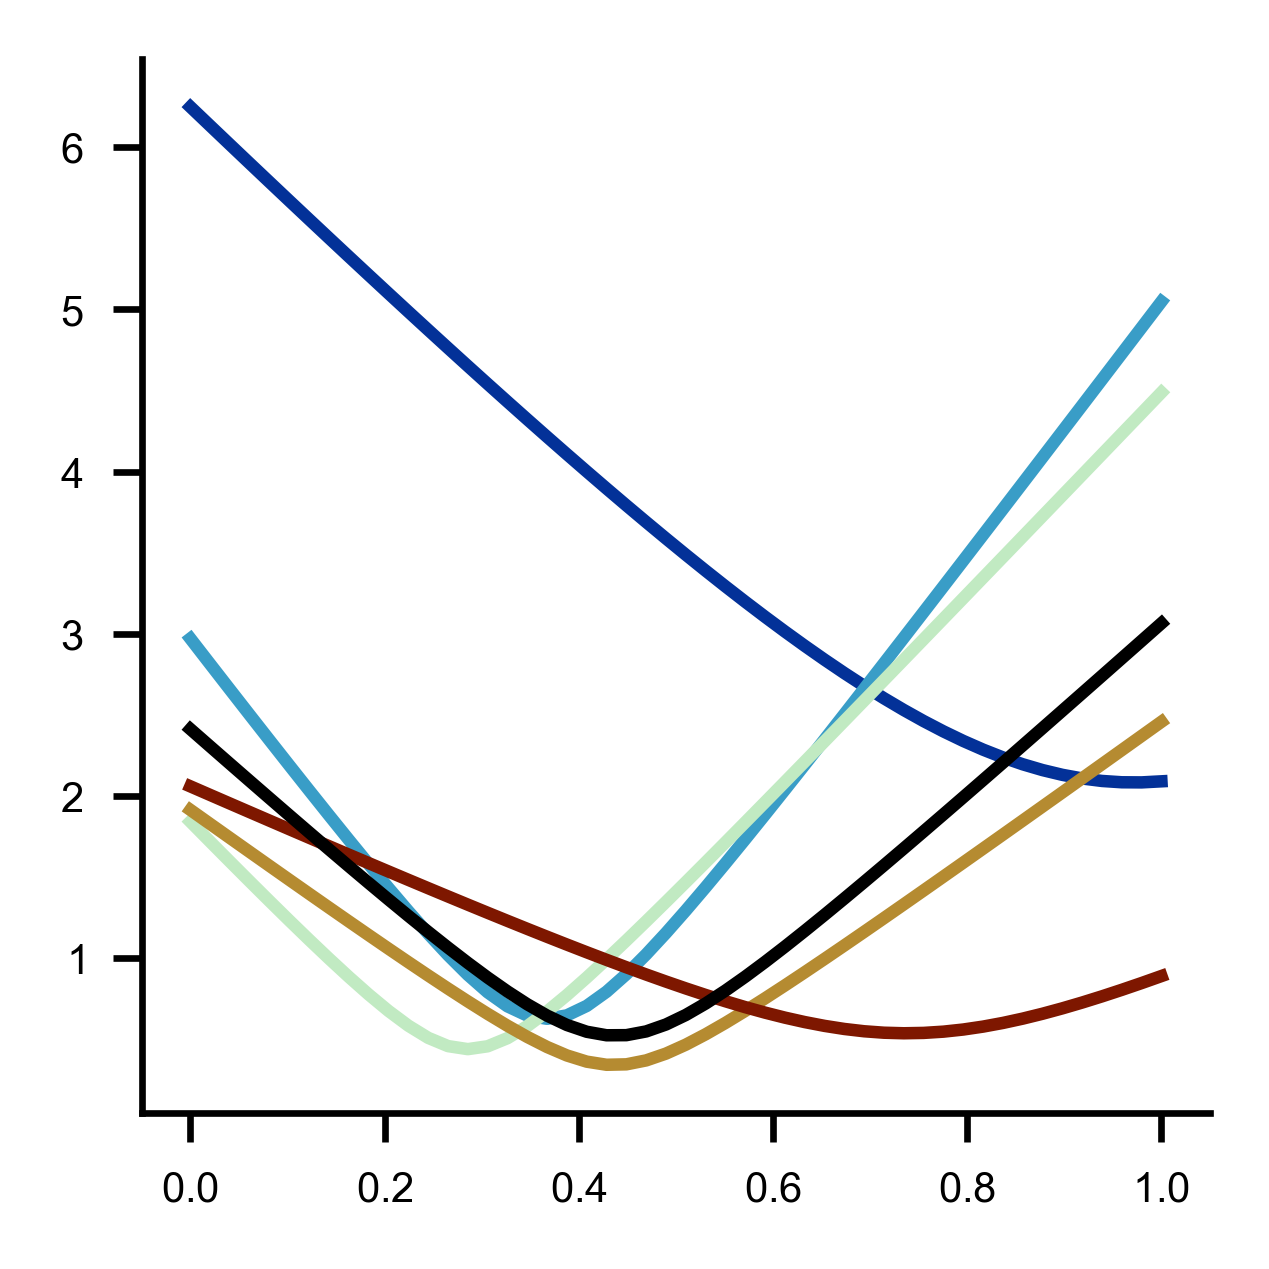

In [115]:
fig, ax = plt.subplots()

behav = h5py.File(bDATAPATH, "r")

for temp in TEMPS:
    # behavior
    v = load_viterbi(bMODELPATH, "g3", temp)
    dt = format_sequences(behav[f"behaviour/{temp}/bouttime"][()])
    bts, dts = sejourn_time_seqs(v, dt)
    sF_beh = dts[bts == 0]
    sL_beh = dts[bts == 1]
    sR_beh = dts[bts == 2]
    s_beh = np.concatenate([sF_beh, sL_beh,sR_beh])

    # neuro
    artrs = ALL_ARTRs[ALL_ARTRs[:,1] == temp]
    sFs, sLs, sRs = [], [], []
    for artr in artrs:
        sF, sL, sR = load_ARTR_sejourn(nMODELPATH, *artr)
        sFs.append(sF)
        sLs.append(sL)
        sRs.append(sR)
    sF_neu = np.concatenate(sFs)
    sL_neu = np.concatenate(sLs)
    sR_neu = np.concatenate(sRs)
    s_neu = np.concatenate([sF_neu, sL_neu, sR_neu])

    diffs_sub = np.array([distrib_diff(dt, s_beh, s_neu) for dt in factors])
    ax.plot(factors, diffs_sub, color=TEMPS_COLS[temp])

behav.close()

ax.plot(factors, diffs, color="k")

## All transitions vs TEMP

In [18]:
mNT = np.array([scaledSimple_nT[nTemps==temp].mean(axis=0) for temp in TEMPS])
semNT = np.array([scaledSimple_nT[nTemps==temp].std(axis=0)/np.sqrt(np.sum(nTemps==temp)) for temp in TEMPS])
msNT = np.array([scaled_nT[nTemps==temp].mean(axis=0) for temp in TEMPS])
semsNT = np.array([scaled_nT[nTemps==temp].std(axis=0)/np.sqrt(np.sum(nTemps==temp)) for temp in TEMPS])

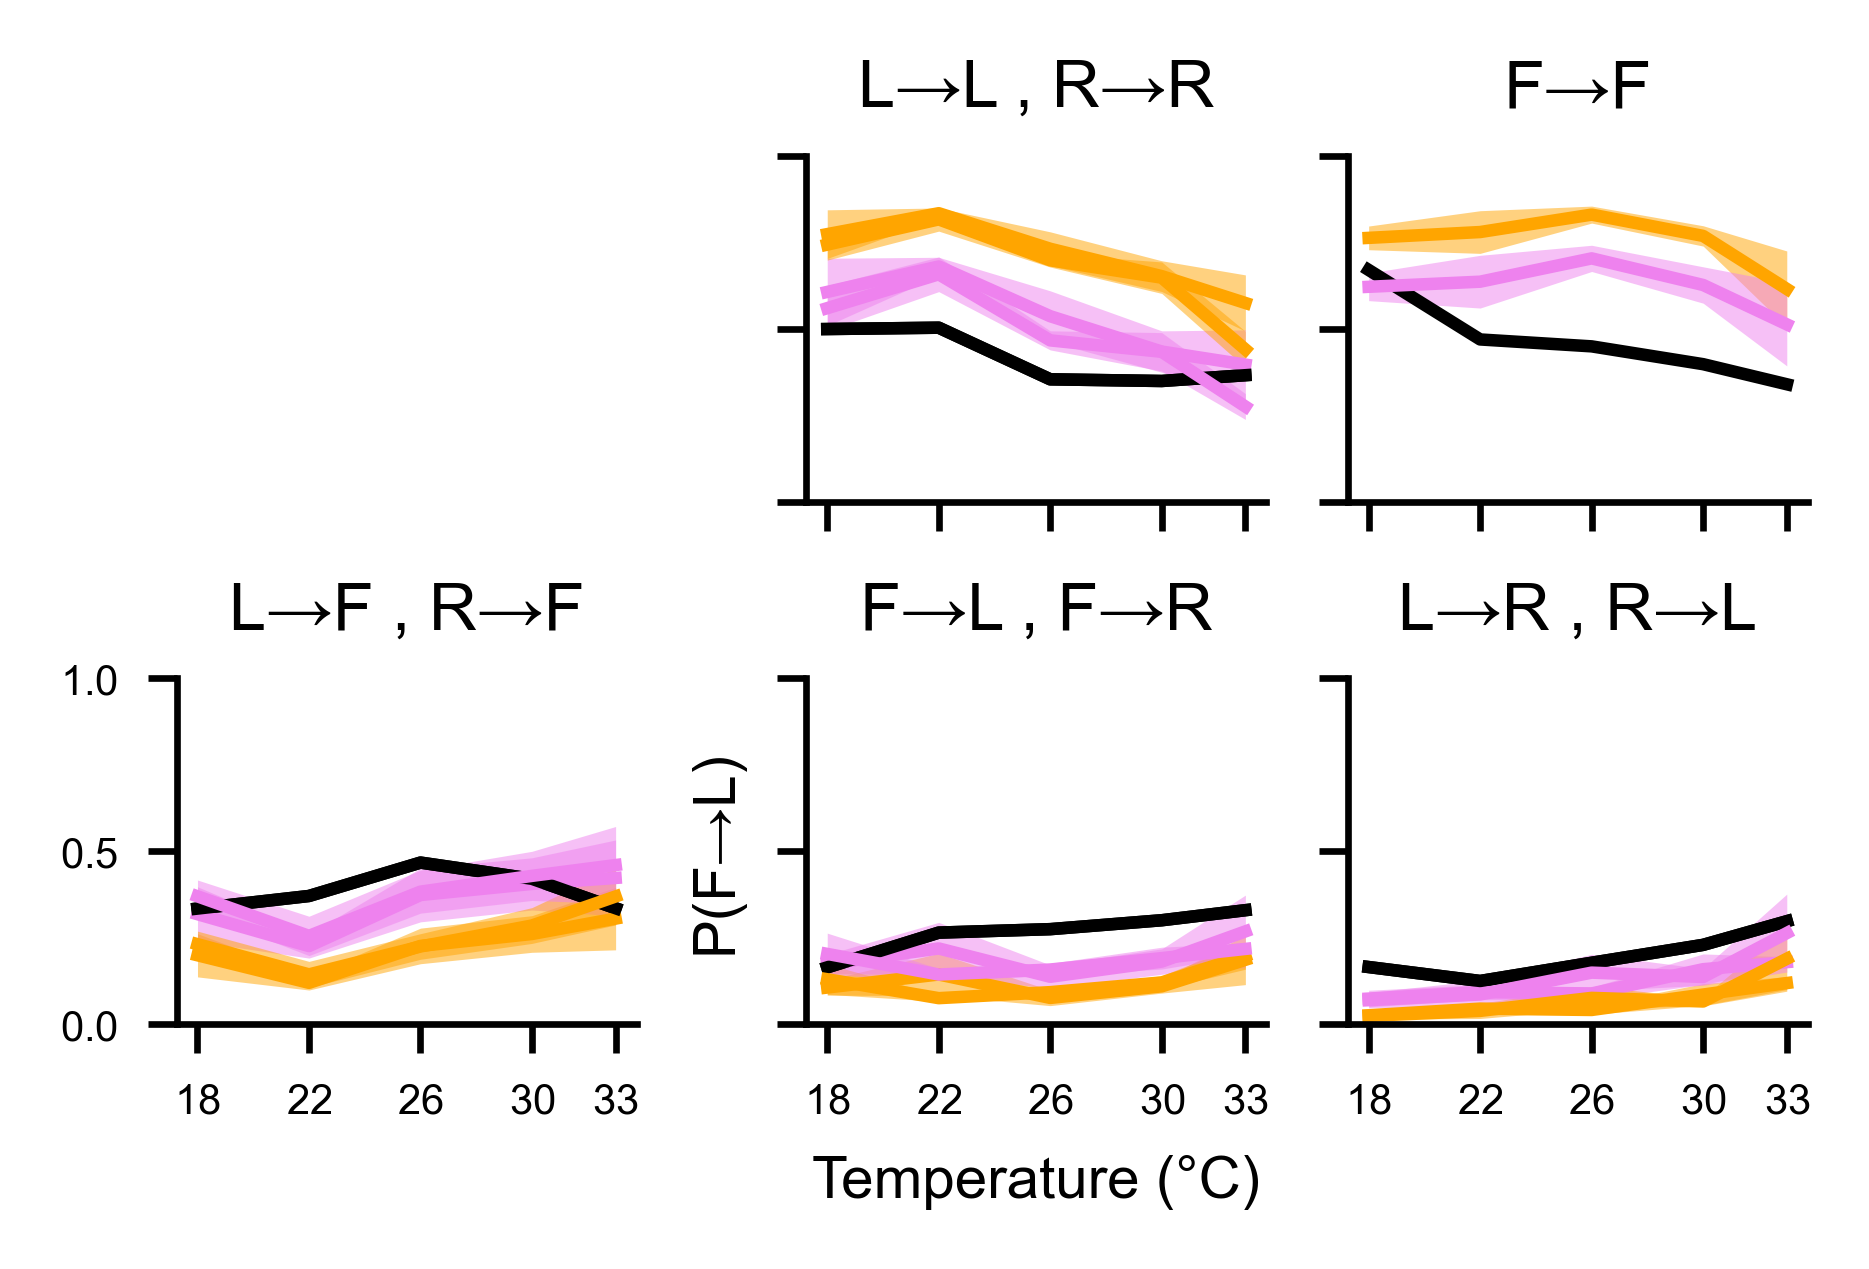

In [19]:
def single_T_plotter(ax, i,j):
    ax.plot(TEMPS, bT[:,i,j], color="k")
    ax.plot(TEMPS, mNT[:,i,j], color="orange")
    ax.fill_between(TEMPS, mNT[:,i,j]-semNT[:,i,j], mNT[:,i,j]+semNT[:,i,j], color="orange", alpha=0.5, zorder=0, linewidth=0)
    ax.plot(TEMPS, msNT[:,i,j], color="violet")
    ax.fill_between(TEMPS, msNT[:,i,j]-semsNT[:,i,j], msNT[:,i,j]+semsNT[:,i,j], color="violet", alpha=0.5, zorder=0, linewidth=0)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*1, 2*1), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.set_title(i)
    ax.set_ylim(0,1)
    ax.set_xticks(TEMPS)
    ax.set_yticks([0,0.5,1])

ax = axs[1]
ax.set_title("L→L , R→R")
single_T_plotter(ax, 1,1)
single_T_plotter(ax, 2,2)

ax = axs[2]
ax.set_title("F→F")
single_T_plotter(ax, 0,0)

ax = axs[3]
ax.set_title("L→F , R→F")
single_T_plotter(ax, 1,0)
single_T_plotter(ax, 2,0)

ax = axs[4]
ax.set_title("F→L , F→R")
single_T_plotter(ax, 0,1)
single_T_plotter(ax, 0,2)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("P(F→L)")

ax = axs[5]
ax.set_title("L→R , R→L")
single_T_plotter(ax, 1,2)
single_T_plotter(ax, 2,1)

axs[0].axis("off")
axs[0].set_title("")

fig.savefig("panels/Fig5/supps/all_transitions.svg")